In [68]:
# -*- coding: utf-8 -*-
# Import libraries
import warnings
import itertools
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from cryptory import Cryptory
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y')

import warnings
warnings.filterwarnings("ignore")

#Define the function meboot
def mean(L):
    return sum(L)/len(L)


def meboot(L, J=1):
    """
    Returns list of J maximum entropy bootstrap samples of time-series L
    """
    N = len(L)
    L_sort = sorted((e,i) for i,e in enumerate(L))
    L_vals = [l[0] for l in L_sort]
    L_inds = [l[1] for l in L_sort]
    L_out = [0]*J
    for j in range(J):
        Z = [(L_vals[i] + L_vals[i+1])/2 for i in range(N-1)]
        m_trm = mean([abs(L[i] - L[i-1]) for i in range(1, N)])
        Z = [L_vals[0] - m_trm] + Z + [L_vals[-1] + m_trm]
        m = [0]*N
        m[0] = 0.75*L_vals[0] + 0.25*L_vals[1]
        for k in range(1, N-1):
            m[k] = 0.25*L_vals[k-1] + 0.5*L_vals[k] + 0.25*L_vals[k+1]
        m[-1] = 0.25*L_vals[-2] + 0.75*L_vals[-1]
        U = sorted([random.random() for _ in range(N)])
        quantiles = [0]*N
        x = [float(y)/N for y in range(N+1)]
        for k in range(N):
            ind = min(range(len(x)), key=lambda i: abs(x[i] - U[k]))
            if x[ind] > U[k]:
                ind -= 1
            c = (2*m[ind] - Z[ind] - Z[ind + 1]) / 2
            y0 = Z[ind] + c
            y1 = Z[ind + 1] + c
            quantiles[k] = y0 + (U[k] - x[ind]) * \
                            (y1 - y0) / (x[ind + 1] - x[ind])
        L_out[j] = [x for y, x in sorted(zip(L_inds, quantiles))]
    return L_out

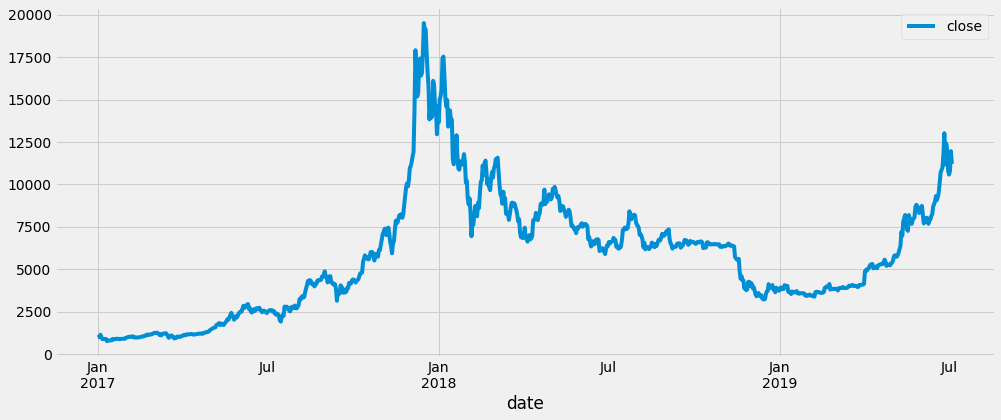

In [69]:
# Load Test Dataset and Plot The Test Dataset
my_cryptory = Cryptory(from_date = "2017-01-01")
df_raw_data = my_cryptory.extract_coinmarketcap("bitcoin")
df_raw_data = df_raw_data.set_index('date').loc[:, ['close']]
df_data = df_raw_data.sort_index(ascending=True)
df_raw_data.plot(figsize=(15, 6))
plt.show()

In [70]:
df_train_data = df_data[0:730]
df_test_data = df_data[730:850]

## Not using Meboot

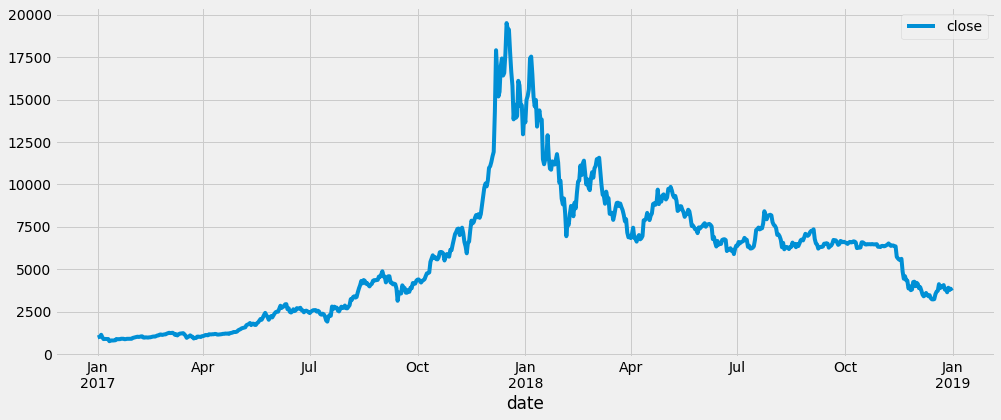

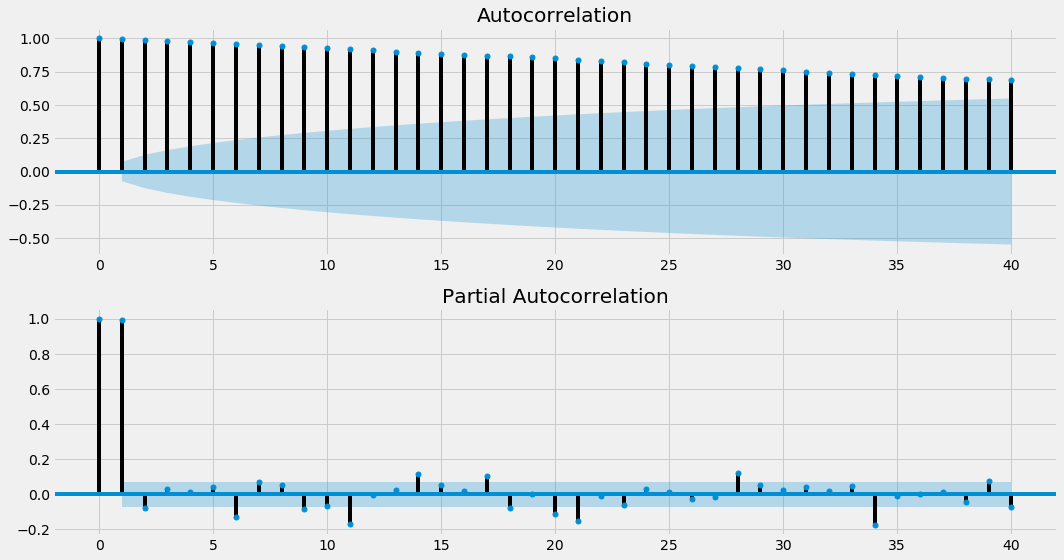

In [71]:
#Plot the Historical Data
df_train_data.plot(figsize=(15,6))
plt.show()
# Plot the Autocorrelation and Partial-Autocorrelation of the bitcoin prices
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(2, 1, 1)
fig = sm.graphics.tsa.plot_acf(df_train_data, lags=40, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(2, 1, 2)
fig = sm.graphics.tsa.plot_pacf(df_train_data, lags=40, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [72]:
#平稳性检测
from statsmodels.tsa.stattools import adfuller
print('原始序列的检验结果为：',adfuller(df_train_data['close']))
#返回值依次为：adf, pvalue p值， usedlag, nobs, critical values临界值 , icbest, regresults, resstore
#adf 分别大于3中不同检验水平的3个临界值，单位检测统计量对应的p 值显著大于 0.05 ， 说明序列可以判定为 非平稳序列

原始序列的检验结果为： (-2.016374712707564, 0.27943983055829402, 20, 709, {'5%': -2.8656251219240572, '1%': -3.439606888036868, '10%': -2.5689454046801052}, 10454.219121139111)


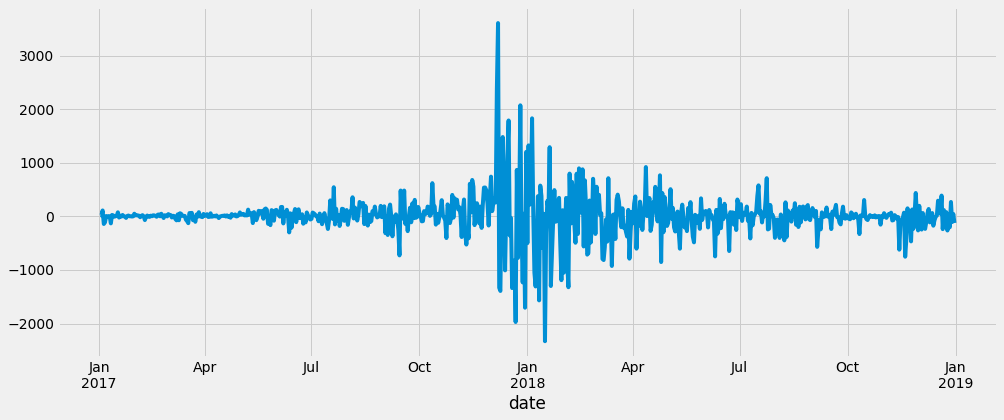

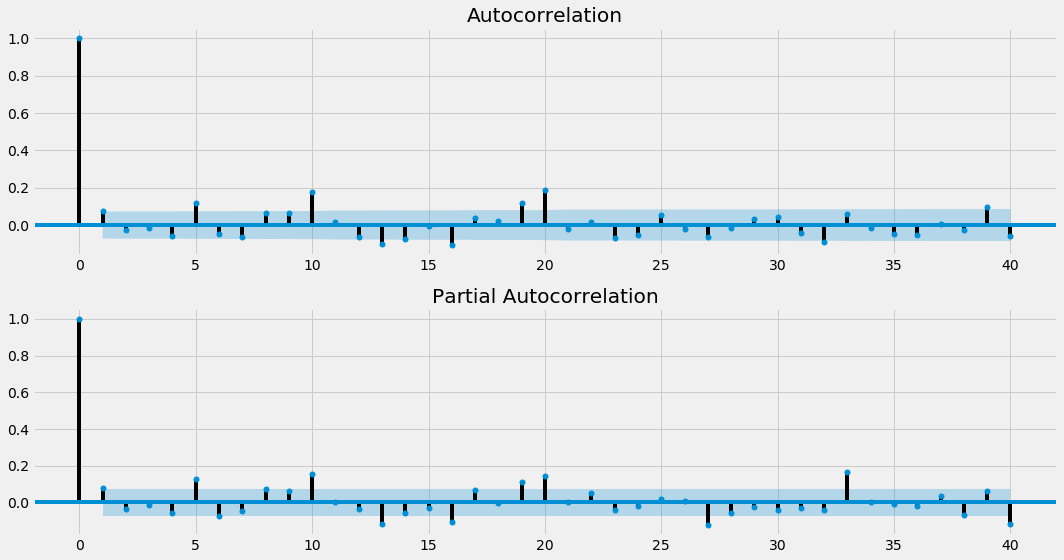

差分序列的ADF 检验结果为：  (-4.9079882594060127, 3.3647021679515488e-05, 19, 709, {'5%': -2.8656251219240572, '1%': -3.439606888036868, '10%': -2.5689454046801052}, 10442.709836696082)


In [100]:
#对数据进行差分后得到 自相关图和 偏相关图
D_data = df_train_data['close'].diff().dropna()
D_data.columns = [u'close difference']

#画出差分后的时序图
D_data.plot(figsize=(15,6))
plt.show()
#画出自相关图
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(2, 1, 1)
fig = sm.graphics.tsa.plot_acf(D_data, lags=40, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()
#画出偏相关图
ax2 = fig.add_subplot(2, 1, 2)
fig = sm.graphics.tsa.plot_pacf(D_data, lags=40, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()
print(u'差分序列的ADF 检验结果为： ', adfuller(D_data))   #平稳性检验
#一阶差分后的序列的时序图在均值附近比较平稳的波动， 自相关性有很强的短期相关性， 单位根检验 p值小于 0.05 ，所以说一阶差分后的序列是平稳序列

In [74]:
#对一阶差分后的序列做白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果：',acorr_ljungbox(D_data, lags= 1)) #返回统计量和 p 值
# 差分序列的白噪声检验结果： (array([11.30402222]), array([0.00077339])) p值为第二项， 小于 0.05

差分序列的白噪声检验结果： (array([ 4.32673018]), array([ 0.03751825]))


### Parameters Tuning

In [103]:
# Setup the test set and training set for time series method
ts_test = df_test_data
ts_train = pd.concat([df_train_data, ts_test])
ts_train_strict = D_data

In [104]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(1, 3)
d = range(1, 3)
q = range(1, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# print('Examples of parameter combinations for Seasonal ARIMA...')
# for index, item in enumerate(pdq):
#     print('SARIMAX: {} x {}'.format(pdq[index], seasonal_pdq[index]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train_strict,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:10455.307653833015
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:10287.045438380937
ARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:10617.937004750087
ARIMA(1, 1, 1)x(1, 2, 2, 12)12 - AIC:10216.772341058908
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:10300.56202993446
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:10288.623520297862
ARIMA(1, 1, 1)x(2, 2, 1, 12)12 - AIC:10779.705365491553
ARIMA(1, 1, 1)x(2, 2, 2, 12)12 - AIC:10237.773682203602
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:10440.100223794961
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:10271.705767654184
ARIMA(1, 1, 2)x(1, 2, 1, 12)12 - AIC:10753.160041824645
ARIMA(1, 1, 2)x(1, 2, 2, 12)12 - AIC:10866.283577214941
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:10300.164207465401
ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:10456.131635986067
ARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:10573.339279182499
ARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:10828.99683678713
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:10720.310957507743
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:10546.0541859

In [105]:
mod = ARIMA(ts_train_strict, (1,1,1)).fit() #建立ARIMA(0, 1, 1)模型
mod.summary2() #给出一份模型报告

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 10797.8606
Dependent Variable: D.close          Log-Likelihood:      -5385.7   
Date:               2019-07-08 14:14 Scale:               1.0000    
No. Observations:   728              Method:              css-mle   
Df Model:           3                Sample:              01-03-2017
Df Residuals:       725                                   12-31-2018
Converged:          1.0000           S.D. of innovations: 393.329   
No. Iterations:     3.0000           HQIC:                10786.584 
AIC:                10779.4994                                      
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const          -0.0774    0.0750    -1.0325  0.3022  -0.2243   0.0695
ar.L1.D.close   0.0767    0.0370     2.0755  0.0383   0.0043   0.1492
ma.L1.D.close  -1.0000    0.0041  -242.9078  0.0000  -1.0081  -0.9919
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           13.0348             0.0000          13.0348             0.0000
MA.1            1.0000             0.0000           1.0000             0.0000
====================================================================

"""

In [106]:
ts_train_real

,0,close
date,,
2017-01-02,23.42,NaN
2017-01-03,22.09,NaN
2017-01-04,110.89,NaN
2017-01-05,-141.35,NaN
2017-01-06,-111.18,NaN
2017-01-07,6.39,NaN
2017-01-08,2.61,NaN
2017-01-09,-8.37,NaN
2017-01-10,4.85,NaN


### Prediction

In [107]:
# Do the prediction with time series cross validation

pred_df = pd.DataFrame()

start_date = '2019-01-01'
ts_train_real = ts_train[:start_date]
mod = sm.tsa.statespace.SARIMAX(ts_train_real, 
                                order=(1, 1, 1), 
                                seasonal_order=(1, 1, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)
results = mod.fit()
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_df = pred_df.append(pred_ci)



# Save Result
# pred_df.to_json('./predicted.csv')

In [108]:
def ts_cross_validation(ts_train, ts_test, pred_df):
    for i, start_date in enumerate(ts_test.index.get_values()):
        if(i < len(ts_test.index.get_values())):
            end_date = ts_test.index.get_values()[i]
            ts_train_real = ts_train[:start_date]
            mod = sm.tsa.statespace.SARIMAX(ts_train_real, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
            results = mod.fit()
            pred = results.get_prediction(start=pd.to_datetime(end_date), dynamic=False)
            pred_ci = pred.conf_int()
            pred_df = pred_df.append(pred_ci)
            print(end_date)
    
    return pred_df

pred_df = ts_cross_validation(ts_train, ts_test, pred_df)  
# Save Result
# pred_df.to_json('./predicted.csv')

2019-01-01T00:00:00.000000000
2019-01-02T00:00:00.000000000
2019-01-03T00:00:00.000000000
2019-01-04T00:00:00.000000000
2019-01-05T00:00:00.000000000
2019-01-06T00:00:00.000000000
2019-01-07T00:00:00.000000000
2019-01-08T00:00:00.000000000
2019-01-09T00:00:00.000000000
2019-01-10T00:00:00.000000000
2019-01-11T00:00:00.000000000
2019-01-12T00:00:00.000000000
2019-01-13T00:00:00.000000000
2019-01-14T00:00:00.000000000
2019-01-15T00:00:00.000000000
2019-01-16T00:00:00.000000000
2019-01-17T00:00:00.000000000
2019-01-18T00:00:00.000000000
2019-01-19T00:00:00.000000000
2019-01-20T00:00:00.000000000
2019-01-21T00:00:00.000000000
2019-01-22T00:00:00.000000000
2019-01-23T00:00:00.000000000
2019-01-24T00:00:00.000000000
2019-01-25T00:00:00.000000000
2019-01-26T00:00:00.000000000
2019-01-27T00:00:00.000000000
2019-01-28T00:00:00.000000000
2019-01-29T00:00:00.000000000
2019-01-30T00:00:00.000000000
2019-01-31T00:00:00.000000000
2019-02-01T00:00:00.000000000
2019-02-02T00:00:00.000000000
2019-02-03

In [109]:
pred_df

,lower close,upper close
2019-01-01,2912.535039,4479.701498
2019-01-01,2912.535039,4479.701498
2019-01-02,3120.683515,4686.749182
2019-01-03,3131.284549,4696.268281
2019-01-04,3045.216827,4614.994373
2019-01-05,3067.583213,4636.757027
2019-01-06,2991.264590,4559.937483
2019-01-07,3420.415863,4981.646217
2019-01-08,3231.028418,4791.145870
2019-01-09,3259.394411,4818.432315


In [81]:
#########多一行数据。。。。
pred_df
pred_df.to_csv('pred.csv')

The Root Mean Squared Error of our forecasts is 124.96


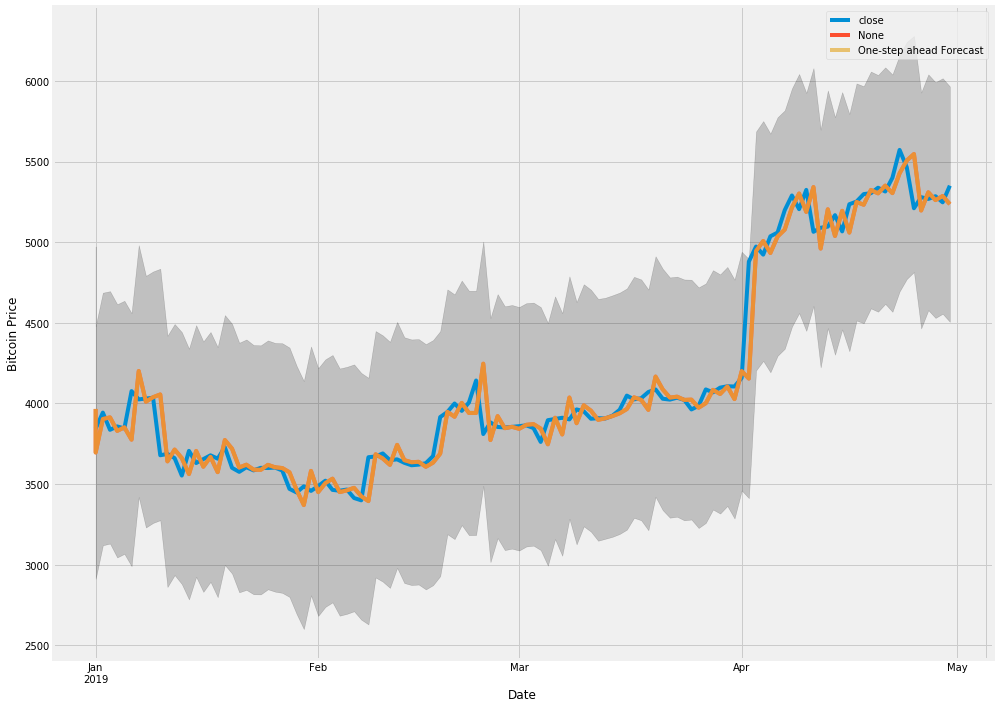

In [66]:
# Load the Prediction result from file system
# pred_df = pd.read_csv('./predicted.csv', sep=',', parse_dates=['date'], index_col='date')
       
pred_mean = (pred_df['upper close'] + pred_df['lower close'])/2

y_forecasted = pred_mean
# Compute the mean square error
mse = ((y_forecasted - ts_test.iloc[:,0]) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# # Plot the Graph
ax = ts_test.plot(label='observed')
pred_mean.plot(figsize=(15, 12))
pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_df.index,
                pred_df['lower close'],
                pred_df['upper close'], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
plt.legend()

plt.show()



In [55]:
y_forecasted

2019-01-01    3966.078265
2019-01-01    3696.118269
2019-01-02    3903.716349
2019-01-03    3913.776415
2019-01-04    3830.105600
2019-01-05    3852.170120
2019-01-06    3775.601036
2019-01-07    4201.031040
2019-01-08    4011.087144
2019-01-09    4038.913363
2019-01-10    4055.948971
2019-01-11    3640.997318
2019-01-12    3714.190927
2019-01-13    3661.416127
2019-01-14    3562.287658
2019-01-15    3705.538061
2019-01-16    3607.994545
2019-01-17    3668.624754
2019-01-18    3574.094220
2019-01-19    3773.227915
2019-01-20    3719.691291
2019-01-21    3602.860952
2019-01-22    3620.471428
2019-01-23    3589.688033
2019-01-24    3588.384513
2019-01-25    3619.438192
2019-01-26    3604.164892
2019-01-27    3599.583138
2019-01-28    3573.488046
2019-01-29    3463.366273
                 ...     
2019-04-01    4200.539236
2019-04-02    4154.344735
2019-04-03    4945.238683
2019-04-04    5007.602068
2019-04-05    4933.288616
2019-04-06    5035.233370
2019-04-07    5078.555631
2019-04-08  

In [57]:
# Output prediction to csv file
output = {'Y_pred': y_forecasted.values.reshape(-1,)}
output = DataFrame(output)
output.to_csv('ARIMA.csv')

In [61]:
ts_test.to_csv('Real.csv')